# Advanced Tutorial 2 : build a Runge-Kutta solver for non-linear ODEs 

📜 _Previous base tutorial on [Runge-Kutta solver](./02_rk.ipynb) focused on the Dahlquist problem to explain how to use the_ $Q$_-coefficients._
_But we can also use those for non-linear ODEs **as long as**_ $Q$ _**is lower triangular**, which is the case for all Runge-Kutta methods._

Consider the following (non-linear) ODE system :

$$
\frac{du}{dt}= f(u,t), \quad u(t_0)=u_0,
$$

where $t_0$ is the initial time. 
Computing the solution after one time-step $u(t_0+\Delta)$ using the $Q$-coefficients (or Butcher table) or size $M$ :

$$
\begin{array}
    {c|c}
    \tau & Q \\
    \hline
    & w^\top
\end{array}
$$

corresponds to approximate the solution at given **time nodes** (or stages)
$[t_1, \dots, t_M$] := [t_0+\Delta{t}\tau_1, \dots, t_0+\Delta{t}\tau_M]$ 
by solving the **all-at-once system** :

$$
{\bf u} - \Delta{t}Q {\bf f} = {\bf u}_0
$$

where 
${\bf u} = [u_1,\dots,u_M]^T$ is the vector containing the node solutions (or stages),
${\bf f} = [f(u_1, t_1),\dots,f(u_M,t_M)]^T$ the evaluations of each node solutions and
${\bf u}_0$ a vector with $u_0$ in each of its entries.

Then, 
$u(t_0+\Delta{t})$ can be approximated via the **step-update** :

$$
u(t_0+\Delta{t}) \simeq
    u_0 + \sum_{m=1}^{M} \omega_{m} f(u_m, t_m)
$$
  
and this process can be repeated for each successive time-step.
 
> 📣 If we do not want to solve the all-at-once problem (which can be very expensive for large problem),
> then $Q$ **must be lower-triangular** to allow solving for $u_1$ first, then for $u_2$ using the $u_1$ solution, etc ... 

## Prerequisite

Consider for example the perturbed Lorenz attractor :

$$
\begin{align}
\frac{dx}{dt} &= \sigma(y-x) \\
\frac{dy}{dy} &= x(\rho(t)-z) - y, \quad \rho(t) = \rho_0 + \epsilon \sin(t) \\
\frac{dz}{dt} &= xy - \beta z
\end{align}
$$

Before solving it, we first need to define its **differential operator** $f(u, t)$ with $u=[x,y,z]^T$
and the associated initial solution $u_0$ for our problem :

In [1]:
import numpy as np

u0 = np.array([5, -5, 20])
sigma, rho0, beta, epsilon = 10, 28, 8/3, 5

def f(u, t):
    x, y, z = u
    rho = rho0 + epsilon*np.sin(t)
    return np.array([sigma*(y-x), x*(rho-z)-y, x*y-beta*z])

In addition, if we want to use an implicit method, we need to define a `fSolve` function that solves

$$
u - \alpha f(u, t) = rhs
$$

for any $\alpha$ and $rhs$, using some `uInit` parameter as initial guess. 
To simplify, we can quickly implement one using the `fsolve` function of `scipy.optimize` (interface for [MINPACK](https://en.wikipedia.org/wiki/MINPACK)) :

In [2]:
from scipy.optimize import fsolve

def fSolve(a, t, rhs, uInit):

    def res(u):
        return u - a*f(u, t) - rhs

    return fsolve(res, uInit)

## Implementation

Let's retrieve some $Q$ coefficients from `qmat` :

In [3]:
from qmat import genQCoeffs
nodes, weights, Q = genQCoeffs("DIRK43")    # Implicit RK method of order three in 4 stages

and define some arrays to store the node solutions, the step solutions and time values :

In [4]:
uNodes = np.zeros((nodes.size, u0.size))

tEnd = 10
nSteps = 1000

uNum = np.zeros((nSteps+1, u0.size))
times = np.linspace(0, tEnd, nSteps+1)

Now, for each time step and time node, we have to solve

$$
u_{m} - \Delta{t}q_{m,m}f(u_m,t_m)
    = u_0 + \Delta{t}\sum_{j=1}^{m-1}q_{m,j}f(u_j, t_j),
$$

and compute the step update at the end :

$$
u(t_0+\Delta{t}) \simeq
    u_0 + \sum_{m=1}^{M} \omega_{m} f(u_m, t_m).
$$

This can be done with the following code :

In [5]:
uNum[0] = u0
for i in range(nSteps):
    dt = times[i+1] - times[i]
    tNodes = times[i] + dt*nodes

    # Solve for each time nodes (stages)
    for m in range(len(nodes)):
        rhs = uNum[i].copy()

        for j in range(m):
            rhs += dt*Q[m, j]*f(uNodes[j], tNodes[j])

        if Q[m,m] == 0:
            uNodes[m] = rhs
        else:
            uNodes[m] = fSolve(dt*Q[m, m], tNodes[m], rhs, uInit=uNum[i])

    # Step update
    uNum[i+1] = uNum[i]
    for m in range(len(nodes)):
        uNum[i+1] += dt*weights[m]*f(uNodes[m], tNodes[m])

And that's it 🥳 ! We solved our non-linear time-dependent ODE on the given time frame, without caring about what's in our $Q$-coefficients ...

> 📣 For a **strictly lower triangular** $Q$ **matrix** (`Q[m,m]=0`), there is no need for the `fSolve` function, as the solution is simply $rhs$.
> That's the case for all **explicit** Runge-Kutta methods. 

We can plot the solution with respect to time : 

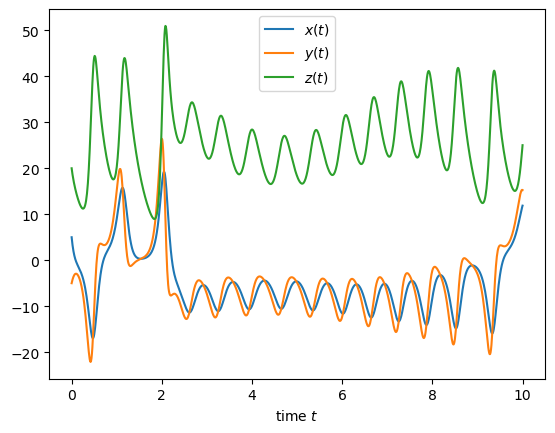

In [6]:
import matplotlib.pyplot as plt

plt.plot(times, uNum[:, 0], label="$x(t)$")
plt.plot(times, uNum[:, 1], label="$y(t)$")
plt.plot(times, uNum[:, 2], label="$z(t)$")
plt.legend(); plt.xlabel("time $t$");

Ideally, the previous code can be written into a function to allow multiple calls :

In [7]:
def solve(nSteps, scheme):

    nodes, weights, Q = genQCoeffs(scheme)
    uNodes = np.zeros((nodes.size, u0.size))

    uNum = np.zeros((nSteps+1, u0.size))
    times = np.linspace(0, tEnd, nSteps+1)

    uNum[0] = u0
    for i in range(nSteps):
        dt = times[i+1] - times[i]
        tNodes = times[i] + dt*nodes

        # Solve for each time nodes (stages)
        for m in range(len(nodes)):
            rhs = uNum[i].copy()

            for j in range(m):
                rhs += dt*Q[m, j]*f(uNodes[j], tNodes[j])

            if Q[m,m] == 0:
                uNodes[m] = rhs
            else:
                uNodes[m] = fSolve(dt*Q[m, m], tNodes[m], rhs, uInit=uNum[i])

        # Step update
        uNum[i+1] = uNum[i]
        for m in range(len(nodes)):
            uNum[i+1] += dt*weights[m]*f(uNodes[m], tNodes[m])

    return times, uNum


... which can be used to try different time schemes or resolution : 

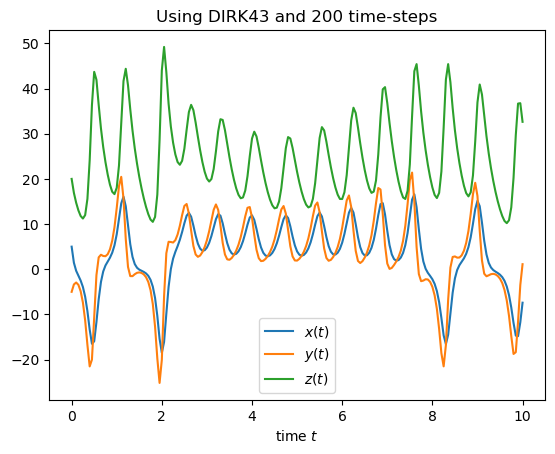

In [8]:
times, uNum = solve(200, "DIRK43")
plt.plot(times, uNum[:, 0], label="$x(t)$")
plt.plot(times, uNum[:, 1], label="$y(t)$")
plt.plot(times, uNum[:, 2], label="$z(t)$")
plt.legend(); plt.xlabel("time $t$"); plt.title("Using DIRK43 and 200 time-steps");

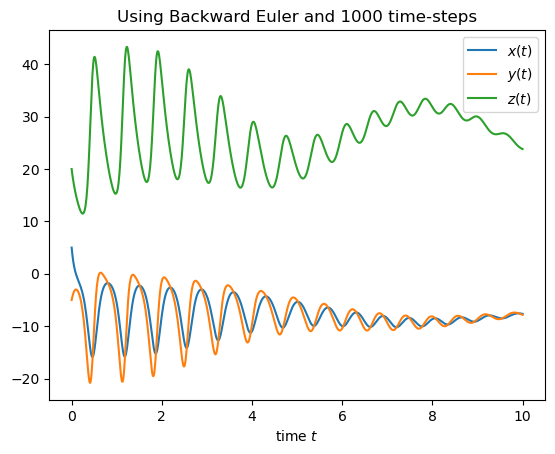

In [9]:
times, uNum = solve(1000, "BE")
plt.plot(times, uNum[:, 0], label="$x(t)$")
plt.plot(times, uNum[:, 1], label="$y(t)$")
plt.plot(times, uNum[:, 2], label="$z(t)$")
plt.legend(); plt.xlabel("time $t$"); plt.title("Using Backward Euler and 1000 time-steps");

## Using the internal RK solver

Such generic Runge-Kutta solver is also available in `qmat` in the `qmat.solvers.generic.CoeffSolver` class, 
and uses a more efficient implementation than the one showed above, requiring less evaluations of $f(u,t)$. 

This implementation is based on a `DiffOp` class (differential operator) 
that implements the $f(u,t)$ evaluation using the following template :

In [ ]:
from qmat.solvers.generic import DiffOp

class Yoodlidoo(DiffOp):
    def __init__(self, params="value"):
        # use some initialization parameters
        u0 = ... # define your initial vector
        super().__init__(u0)

    def evalF(self, u, t, out:np.ndarray):
        r"""
        Evaluate :math:`f(u,t)` and store the result into `out`.

        Parameters
        ----------
        u : np.ndarray
            Input solution for the evaluation.
        t : float
            Time for the evaluation.
        out : np.ndarray
            Output array in which is stored the evaluation.
        """
        out[:] = ... # put the result into out

📣 Note that the `evalF` function does not return the result, 
but rather put the result of the evaluation into the `out` array.
This allows a memory efficient implementation of the different solvers that avoids any implicit data copy.

> 🔔 The `DiffOp` base class also provide a default `fSolve` method, so you don't need to implement it.

Some differential operators are already provided in `qmat` ...
for example, to solve the non-perturbed Lorenz system using a Runge-Kutta approach :

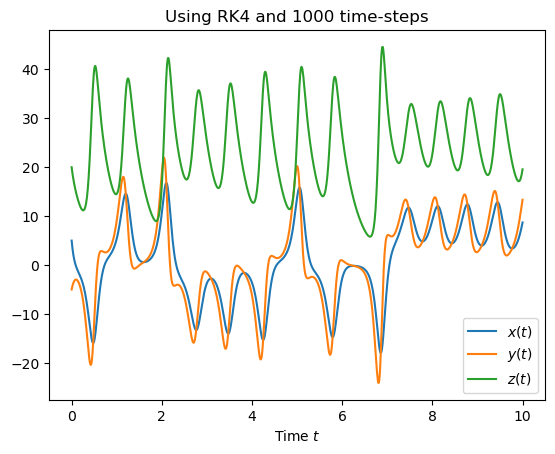

In [10]:
from qmat import genQCoeffs
from qmat.solvers.generic import CoeffSolver
from qmat.solvers.generic.diffops import Lorenz

scheme = "RK4"
nSteps = 1000

solver = CoeffSolver(Lorenz(), tEnd=10, nSteps=nSteps)

nodes, weights, Q = genQCoeffs(scheme)
uNum = solver.solve(Q, weights)

plt.plot(solver.times, uNum[:, 0], label="$x(t)$")
plt.plot(solver.times, uNum[:, 1], label="$y(t)$")
plt.plot(solver.times, uNum[:, 2], label="$z(t)$")
plt.legend(); plt.xlabel("Time $t$"); plt.title(f"Using {scheme} and {nSteps} time-steps");

Eventually, you can also add your own differential operator into `qmat`, see the [short developer guide](../devdoc/addDiffOp.md) on this aspect ... 

> 📣 Note that this Runge-Kutta solver does not work if $Q$ is a dense matrix.
> In that case, we can eventually use the Spectral Deferred Correction approach without too much additional code,
> which is the topic of the [next advanced tutorial ...](./13_nonLinearSDC.ipynb)